In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os
import __main__

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.data_transform import log_moulus_nfold
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid, GRID_SHAPE
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

isCNN = True
isTrain = True
epochs = 100
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1'

if not hasattr(__main__, 'get_ipython'):
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help="Train model")
    parser.add_argument('--test', action='store_false', dest='train', help="Test model only")
    parser.set_defaults(train=True)
    parser.add_argument('--cnn', action='store_true', help="Train with CNN")
    parser.add_argument('--fcn', action='store_false', dest='cnn', help="Train with FCN")
    parser.set_defaults(cnn=True)
    parser.add_argument('-e', type=int, nargs='?', default=epochs, help="Epochs of train", metavar='Epochs')
    parser.add_argument('-trial', type=str, nargs='?', default=TRIAL_NAME, help="Trial name", metavar='Trial')
    args = parser.parse_args()
    isTrain = args.train
    isCNN = args.cnn
    epochs = args.e
    TRIAL_NAME = args.trial

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

if isCNN:
    try:
        LFP = np.load(LFP_PATH)
    except:
        LFP = NpzFilesCollector(LFP_PATH)
    with LFP:
        lfp = LFP['x'] * 1000 # convert to uV
        labels = LFP['y'][LFP['good_indices']]
        ys = LFP['ys']
else:
    try:
        STATS = np.load(STATS_PATH)
    except:
        STATS = NpzFilesCollector(STATS_PATH)
    with STATS:
        summ_stats = STATS['x']
        labels = STATS['y']
        ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
3,5.755159,52.479145,0.014425,695.607342,0.159487,0.536712,0.658876
2,10.046336,56.146029,-0.217564,695.607342,0.159487,0.536712,0.658876
1,30.866634,90.468007,-0.441715,1049.496815,0.118905,0.431152,0.668250
0,40.094641,145.544253,-0.245650,1049.496815,0.118905,0.431152,0.668250


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.00% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,0.267298,0.273923,-0.234578,0.726358,-0.400576,-0.943361,0.341249
1,0.205778,-0.460427,-0.421807,0.726358,-0.400576,-0.943361,0.341249
2,0.066976,-0.918053,-0.207758,0.082922,-0.154626,-0.751433,0.294379
3,0.038368,-0.966945,0.013775,0.082922,-0.154626,-0.751433,0.294379


## Build model

In [7]:
if isCNN:
    n_fold = 30
    max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
    n_fold = 2**max_logmod - 1
    
    lfp_trans = np.empty_like(lfp)
    for i in range(lfp.shape[0]):
        lfp_trans[i] = log_moulus_nfold(lfp[i], n_fold)
    
    lfp_trans = np.stack((lfp, lfp_trans), axis=1)
    lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

In [8]:
import torch

batch_size = 256
model_name = '_batch' + str(batch_size)
rand_seed = 0
torch.manual_seed(rand_seed)

if isCNN:
    from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
    model_name = 'CNN' + model_name
    num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
    model = ConvolutionalNetwork(in_channels=lfp_trans.shape[1], out_features=len(label_list), num_filters=num_filters)
else:
    from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
    model_name = 'FCN' + model_name
    model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
if isTrain and not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print("The new model directory is created!")

PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.pth')
SAVE_PATH = os.path.join(MODEL_PATH, model_name + '.txt')

The new model directory is created!


## Train model

In [9]:
from cell_inference.utils.feature_extractors.helperfunctions import train_model, build_dataloader_from_numpy

if isCNN:
    train_size = 0.8 if isTrain else 0.
    train_loader, test_loader = build_dataloader_from_numpy(
        input_arr=lfp_trans, label_arr=labels, batch_size=batch_size, train_size=train_size, shuffle=True
    )
else:
    train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, label_arr=labels, batch_size=batch_size, shuffle=True)

if isTrain:
    history, files = train_model(model, train_loader, test_loader, epochs=epochs, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), PARAM_PATH)
    with open(SAVE_PATH, 'w') as f:
        f.writelines(s + '\n' for s in files)

 10%|████▎                                      | 1/10 [00:00<00:04,  1.89it/s]

Training Loss: 0.10794568061828613 Validation Loss: 0.27686306834220886


100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


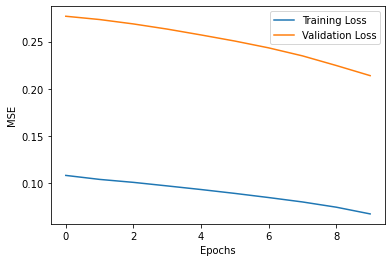

In [10]:
if not isTrain:
    with open(SAVE_PATH, 'r') as f:
        loss_file = f.read().splitlines()[1]
        loss_file = loss_file.split(os.path.sep)[-1].split('/')[-1]
        loss_file = os.path.join(paths.LOSSES_ROOT, loss_file)
    history = pd.read_csv(loss_file).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

### Perform on stylized model

In [11]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device('cpu')
if not isTrain:
    model.load_state_dict(torch.load(PARAM_PATH, map_location=torch.device('cpu')))
model.to(device)
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

R2 Score:
y-shift,   nan
d,         nan
theta,     nan
l_t,       nan
lr_pt,     nan
r_t,       nan
rr_dt,     nan


E:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
E:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
E:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
E:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
E:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Stylized Cell Testing Data: Ground Truth VS Predicted


E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWar

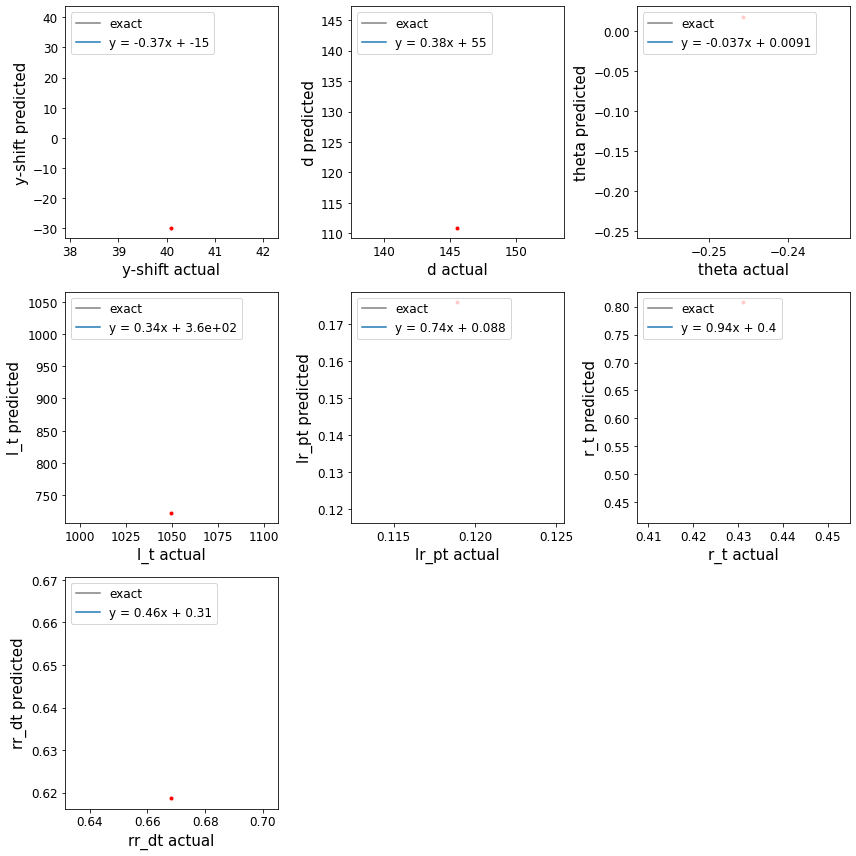

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(MODEL_PATH, 'test_result.pdf'))

#### Check prediction on orientation

In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 30
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 8))
    angle *= 180 / np.pi
    h_err = 180 / np.pi * (np.arccos(output[:, orient_idx2[0]]) - np.arccos(y[:, orient_idx2[0]]))
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    # angle error vs. h angle
    fig1 = plt.figure(figsize=(10, 8))
    # h error
    plt.subplot(311)
    plt.axhline(0, color='k')
    plt.plot(h_angle, h_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('h error (deg)')
    # phi error
    plt.subplot(312)
    plt.axhline(0, color='k')
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(313)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 90])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error vs. trunk length
    try:
        l_t_idx = display_list.index('l_t')
    except:
        l_t_idx = None
    if l_t_idx is not None:
        l_t = y[:, l_t_idx]
        fig2 = plt.figure(figsize=(10, 8))
        # h error
        plt.subplot(311)
        plt.axhline(0, color='k')
        plt.plot(l_t, h_err, 'r.')
        plt.ylim([-90, 90])
        plt.ylabel('h error (deg)')
        # phi error
        plt.subplot(312)
        plt.axhline(0, color='k')
        plt.plot(l_t, phi_err, 'r.')
        plt.ylim([-90, 90])
        plt.ylabel('phi error (deg)')
        # angle error
        plt.subplot(313)
        plt.plot(l_t, angle, 'r.')
        plt.ylim([0, 90])
        plt.xlabel('true trunk length')
        plt.ylabel('angle error (deg)')
        
        fig2.savefig(os.path.join(MODEL_PATH, 'angle_error_vs_trunk_length.png'))

    # angle error distribution
    fig3 = plt.figure(figsize=(10, 6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 90))
    plt.xlim([0, 90])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 90), density=True, weights=weights)
    plt.xlim([0, 90])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

    fig1.savefig(os.path.join(MODEL_PATH, 'angle_error_vs_h.png'))
    fig3.savefig(os.path.join(MODEL_PATH, 'angle_error_distribution.png'))